In [17]:
import re
import numpy as np
import pandas as pd
import missingno as mno

In [18]:
df = pd.read_csv('cleaned.csv')
df.head()

,Unnamed: 0,address,areas,bathrooms,bedrooms,parking-spaces,price,price-item-0,price-item-1,Unnamed: 9
0,0,"Rua João Barros Moreira, Recreio dos Bandeirantes",450 m²,7.0,4.0,3.0,R$ 5.000 /mês,condomínio R$ 1.242,IPTU R$ 481,NaN
1,1,"Rua João Pinheiro, Piedade",56 m²,2.0,2.0,1.0,R$ 1.300 /mês,condomínio R$ 460,IPTU R$ 60,NaN
2,2,"Estrada dos Bandeirantes, Jacarepaguá",61 m²,2.0,2.0,1.0,R$ 1.380 /mês,condomínio R$ 600,IPTU R$ 89,NaN
3,3,"Rua Mário Covas Júnior, Barra da Tijuca",97 m²,3.0,2.0,1.0,R$ 2.950 /mês,condomínio R$ 852,IPTU R$ 315,NaN
4,4,"Rua Coronel Paulo Malta Rezende, Barra da Tijuca",65 m²,2.0,2.0,1.0,R$ 2.400 /mês,condomínio R$ 809,IPTU R$ 218,NaN


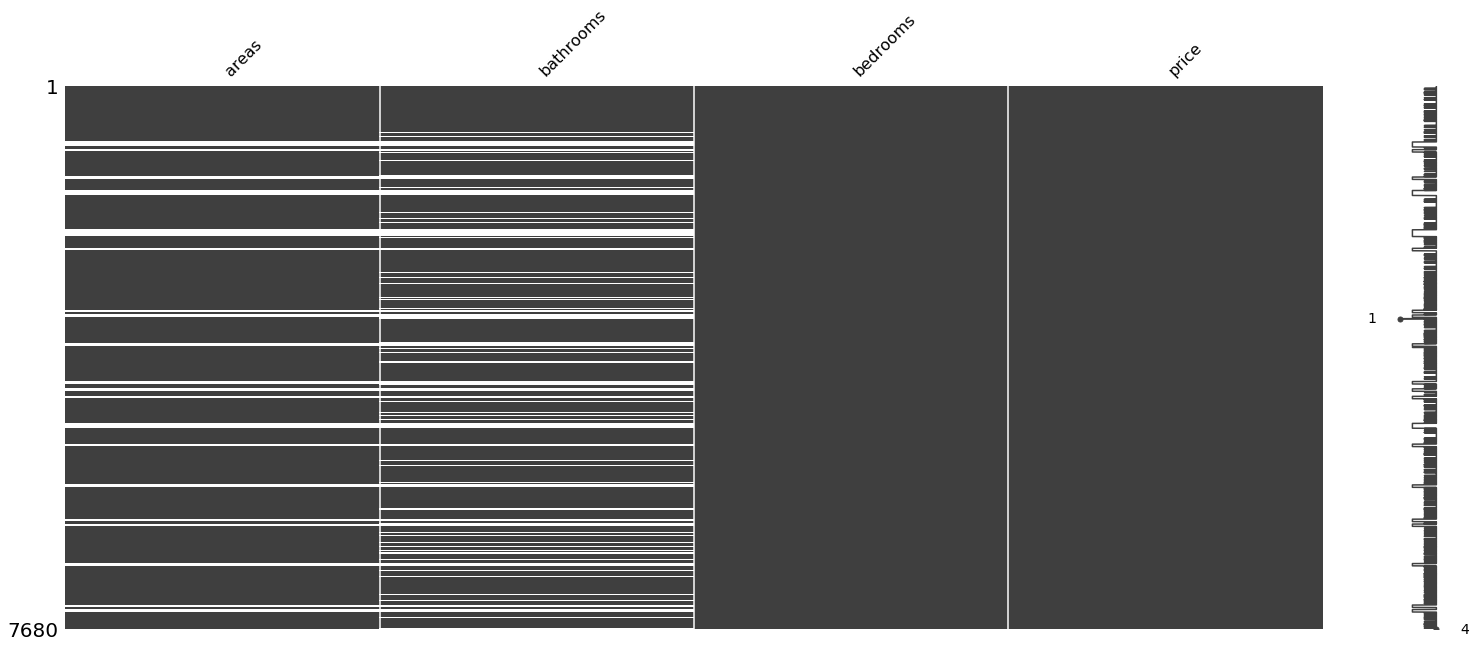

In [12]:
df.drop(columns=['address', 'parking-spaces', 'price-item-0',
                'price-item-1', 'Unnamed: 0', 'Unnamed: 9'], inplace=True)
mno.matrix(df)

In [16]:
df.head()

,areas,bathrooms,bedrooms,price
0,450 m²,7.0,4.0,R$ 5.000 /mês
1,56 m²,2.0,2.0,R$ 1.300 /mês
2,61 m²,2.0,2.0,R$ 1.380 /mês
3,97 m²,3.0,2.0,R$ 2.950 /mês
4,65 m²,2.0,2.0,R$ 2.400 /mês
